<div style="line-height:0.5">
<h1 style="color:#9865A9"> Curve Fitting examples 2 </h1>
</div>
<div style="line-height:1.5">
<div style="margin-top: -10px;">
<span style="display: inline-block;">
    <h3 style="color: lightblue; display: inline;">Keywords:</h3> lmfit + fftpack + numpy polyfit
</span>
</div>
</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.fftpack import fft, ifft
from scipy.interpolate import UnivariateSpline

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import lmfit
from lmfit.models import StepModel, LinearModel


<h2 style="color:#9865A9"> <u> Ex 1: </u> </h2>

In [2]:
#### Generate data
np.random.seed(0)
xdata = np.linspace(0., 1000., 1000)
ydata = -np.ones(1000)
ydata[500:1000] = 1.

ydata[:15], ydata.shape

(array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.]),
 (1000,))

In [3]:
# Add a linear step
ydata[490:510] = -1 + np.arange(20)/10.0
ydata = ydata + np.random.normal(size=len(xdata), scale=0.1)

# Model data as Step + Line
step_mod = StepModel(form='linear', prefix='step_')
line_mod = LinearModel(prefix='line_')

model = step_mod + line_mod

# Define parameters giving initial values:
pars = model.make_params(line_intercept=ydata.min(),
                        line_slope=0,
                        step_center=xdata.mean(),
                        step_amplitude=ydata.std(),
                        step_sigma=2.0)

# Fit 
out = model.fit(ydata, pars, x=xdata)

print(out.fit_report())

[[Model]]
    (Model(step, prefix='step_', form='linear') + Model(linear, prefix='line_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 1000
    # variables        = 5
    chi-square         = 9.72660131
    reduced chi-square = 0.00977548
    Akaike info crit   = -4622.89074
    Bayesian info crit = -4598.35197
    R-squared          = 0.99020069
[[Variables]]
    step_amplitude:  1.98946659 +/- 0.01304854 (0.66%) (init = 0.996283)
    step_center:     500.479268 +/- 0.22603765 (0.05%) (init = 500)
    step_sigma:      20.6227796 +/- 0.77215156 (3.74%) (init = 2)
    line_slope:      1.3947e-05 +/- 2.2340e-05 (160.18%) (init = 0)
    line_intercept: -1.00628056 +/- 0.00706005 (0.70%) (init = -1.277259)
[[Correlations]] (unreported correlations are < 0.100)
    C(step_amplitude, line_slope)     = -0.8749
    C(line_slope, line_intercept)     = -0.7744
    C(step_amplitude, line_intercept) = +0.4610
    C(step_amplitude, step_s

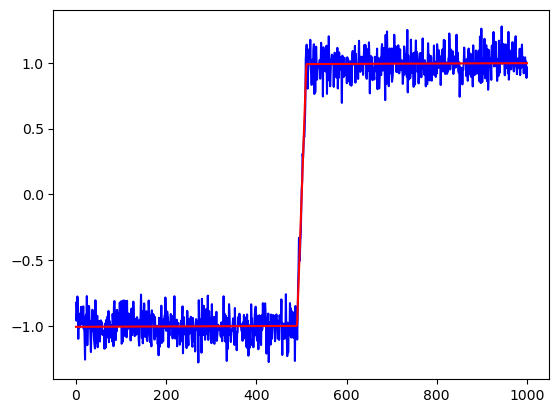

In [4]:
plt.plot(xdata, ydata, 'b')
plt.plot(xdata, out.best_fit, 'r-')
plt.show()

<h2 style="color:#9865A9"> <u> Ex 2: </u> </h2>

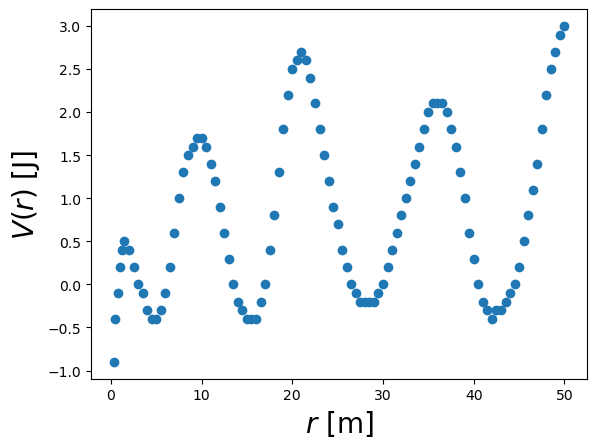

In [5]:
data2 = np.loadtxt('./data_outputs/curvefit2.txt', delimiter=',')

r_data, V_data = data2[:,0], data2[:,1]

plt.scatter(r_data, V_data)
plt.xlabel('$r$ [m]', fontsize=20)
plt.ylabel('$V(r)$ [J]', fontsize=20)
plt.show()

<h3> First Tentative to change model... </h3>

In [6]:
def model_f(r, sigma, epsilon):
    return 4*epsilon*((sigma/r)**12-(sigma/r)**6)

In [7]:
""" Initial guesses """
eps_init_guess = 120
sig_init_guess = 2**(-1/6) * 0.4

In [8]:
popt, pcov = curve_fit(model_f, r_data, V_data, p0=[sig_init_guess, eps_init_guess])
sig_opt, eps_opt = popt

In [9]:
r_model = np.linspace(min(r_data), max(r_data), 1000)
V_model = model_f(r_model, sig_opt, eps_opt)


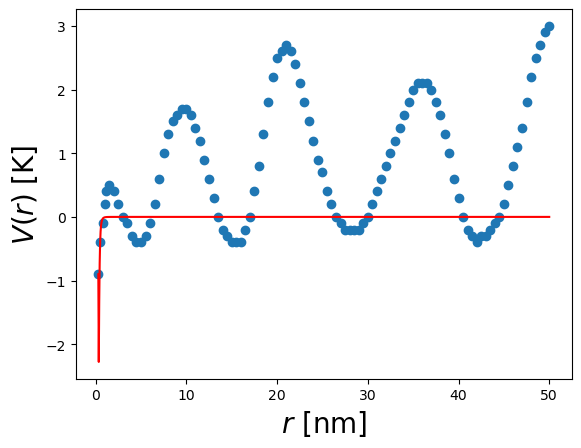

In [10]:
plt.scatter(r_data, V_data)
plt.plot(r_model, V_model, color='r')
plt.xlabel('$r$ [nm]', fontsize=20)
plt.ylabel('$V(r)$ [K]', fontsize=20)
plt.show()

In [11]:
print(f"sig_opt {sig_opt}")
print(f"eps_opt {eps_opt}")

sig_opt 0.2947228121593788
eps_opt 2.4777987883860404


<h3> Second Tentative to change model </h3>

In [12]:
def model_f(r, a, b, c, d):
    return a * np.exp(-b * r) * np.sin(c * r + d)

#### Initial guesses for parameters
a_init_guess = 3.0
b_init_guess = 0.1
c_init_guess = 0.5
d_init_guess = np.pi / 2

# Fit 
popt, pcov = curve_fit(model_f, r_data, V_data, p0=[a_init_guess, b_init_guess, c_init_guess, d_init_guess])

print('a =', popt[0])
print('b =', popt[1])
print('c =', popt[2])
print('d =', popt[3])

a = 0.9386775766923604
b = 0.17329838176958512
c = 1.0245496590046181
d = -0.8539943860962441


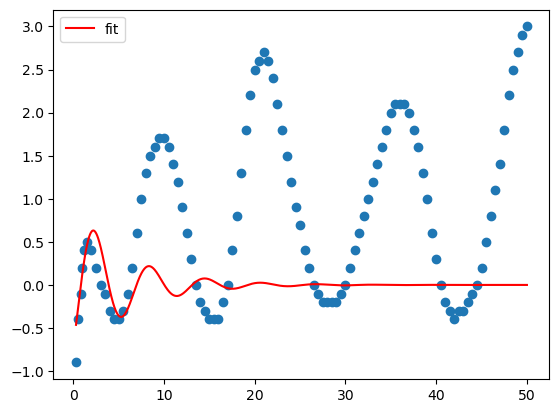

In [13]:
#### Plot
plt.scatter(r_data, V_data)
r_model = np.linspace(np.min(r_data), np.max(r_data), 1000)
V_model = model_f(r_model, *popt)
plt.plot(r_model, V_model, 'r-', label='fit')
plt.legend()
plt.show()

<h3> Third Tentative to change model </h3>

In [14]:
def model_f(r, a1, f1, p1, a2, f2, p2, a3, f3, p3, c):
    return a1 * np.sin(2*np.pi*f1*r + p1) \
         + a2 * np.sin(2*np.pi*f2*r + p2) \
         + a3 * np.sin(2*np.pi*f3*r + p3) + c

# initial guesses for parameters...increasing this params the function get thicker
# a1_init_guess = 1.0
# f1_init_guess = 0.1
# p1_init_guess = 0.0
# a2_init_guess = 1.0
# f2_init_guess = 0.2
# p2_init_guess = 0.0
# a3_init_guess = 1.0
# f3_init_guess = 0.3
# p3_init_guess = 0.0
# c_init_guess = 0.0
a1_init_guess = 5.0
f1_init_guess = 0.1
p1_init_guess = 3.0
a2_init_guess = 5.0
f2_init_guess = 0.2
p2_init_guess = 3.0
a3_init_guess = 5.0
f3_init_guess = 2.3
p3_init_guess = 1.0
c_init_guess = np.mean(V_data)

# fit model to data
popt, pcov = curve_fit(model_f, r_data, V_data, p0=[
    a1_init_guess, f1_init_guess, p1_init_guess,
    a2_init_guess, f2_init_guess, p2_init_guess,
    a3_init_guess, f3_init_guess, p3_init_guess,
    c_init_guess])

# print results
print('a1 =', popt[0])
print('f1 =', popt[1])
print('p1 =', popt[2])

print('a2 =', popt[3])
print('f2 =', popt[4])
print('p2 =', popt[5])

print('a3 =', popt[6])
print('f3 =', popt[7])
print('p3 =', popt[8])

print('c =', popt[9])

a1 = 0.4577612966109397
f1 = 0.10426547846363599
p1 = 1.344083960990507
a2 = 0.18648494037158583
f2 = 0.19667879184204834
p2 = 3.8276534157507327
a3 = -0.09905964925414128
f3 = 2.2884141142133347
p3 = 3.04195464562356
c = 0.7806370190969987


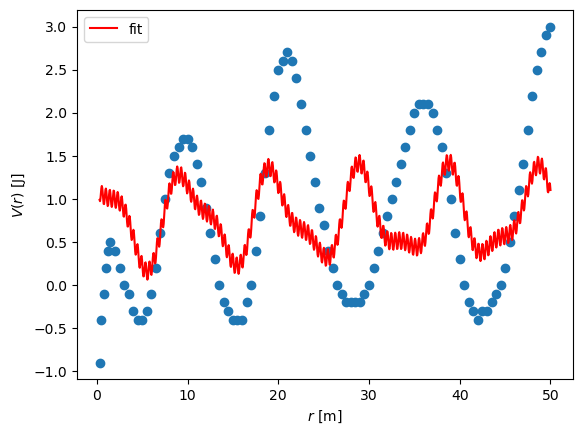

In [15]:
####### Plot fit and data
plt.scatter(r_data, V_data)
plt.xlabel('$r$ [m]', fontsize=10)
plt.ylabel('$V(r)$ [J]', fontsize=10)
r_model = np.linspace(np.min(r_data), np.max(r_data), 1000)
V_model = model_f(r_model, *popt)
plt.plot(r_model, V_model, 'r-', label='fit')
plt.legend()
plt.show()

<h2 style="color:#9865A9"> Polyfit </h2>
Instead of curve_fit

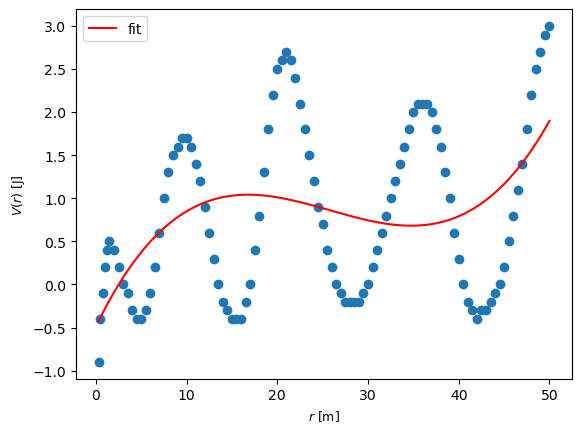

In [16]:
## Fit polynomial
degree = 3  # degree of polynomial to fit
coeffs = np.polyfit(r_data, V_data, degree)
# Create polynomial function
poly_f = np.poly1d(coeffs)

## Evaluate polynomial on a grid of points
r_grid = np.linspace(np.min(r_data), np.max(r_data), 1000)
V_grid = poly_f(r_grid)

##### Plot data and fit
plt.scatter(r_data, V_data)
plt.xlabel('$r$ [m]', fontsize=9)
plt.ylabel('$V(r)$ [J]', fontsize=9)
plt.plot(r_grid, V_grid, 'r-', label='fit')
plt.legend()
plt.show()

<div style="line-height:0.4">
<h2 style="color:#9865A9"> Splines </h2>
</div>

If the data has sharp changes in slope or curvature, one solution could be considering fitting a spline curve to the data.

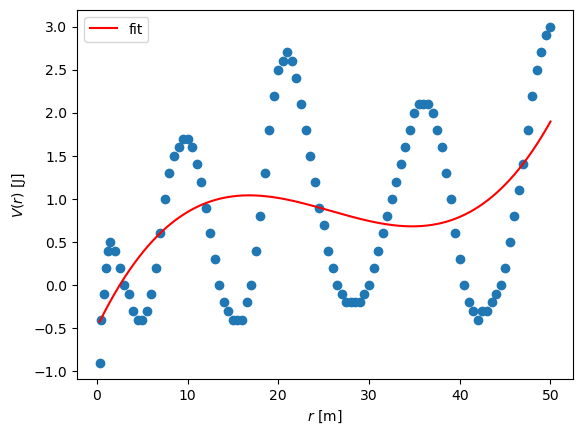

In [17]:
# Fit spline
spline_f = UnivariateSpline(r_data, V_data)

# Evaluate spline on a grid of points
r_grid = np.linspace(np.min(r_data), np.max(r_data), 1000)
V_grid = spline_f(r_grid)

##### Plot data and fit
plt.scatter(r_data, V_data)
plt.xlabel('$r$ [m]', fontsize=10)
plt.ylabel('$V(r)$ [J]', fontsize=10)
plt.plot(r_grid, V_grid, 'r-', label='fit')
plt.legend()
plt.show()

<div style="line-height:0.4">
<h2 style="color:#9865A9"> Fourier series </h2>
</div>

**Recap:** <br>
When data have periodic oscillations Fourier models can be used to decompose a signal into its frequency components, <br>
by expressing it as a sum of complex exponential functions of different frequencies.   
The result of the transform is a complex-valued function of frequency, <br>
which represents the amplitudes and phases of the sinusoids that make up the signal.

<div style="line-height:0.4">
<h4 style="color:#9865A9"> Why inversion? </h4>
</div>

=> To convert a frequency-domain signal into a time-domain signal!       
The inversion allows to obtain a final fit in the time domain that can be used to make predictions or analyze the original signal. <br>
Ftt takes a signal that has been decomposed into its frequency components and reconstructs the original signal in the time domain.

The inverse Fourier transform is crucial in curve fitting that the curve fitting process is performed in the frequency domain.   
So we need to transform the fitted signal back to the time domain to obtain the final result.



In [18]:
# Compute Fourier transform of data ; V_fft are the coefficients
V_fft = fft(V_data)

## Construct the frequency domain (a sum of sinusoidal functions of different frequencies, each with an amplitude and a phase)
n = len(V_data)
freq = np.fft.fftfreq(n, d=np.mean(np.diff(r_data)))

## Set high-frequency components of the Fourier transform to zero (above a cutoff frequency)
cutoff_freq = 0.1  # set cutoff frequency
V_fft[np.abs(freq) > cutoff_freq] = 0

# Compute inverse Fourier transform to obtain fit
V_fit = ifft(V_fft)

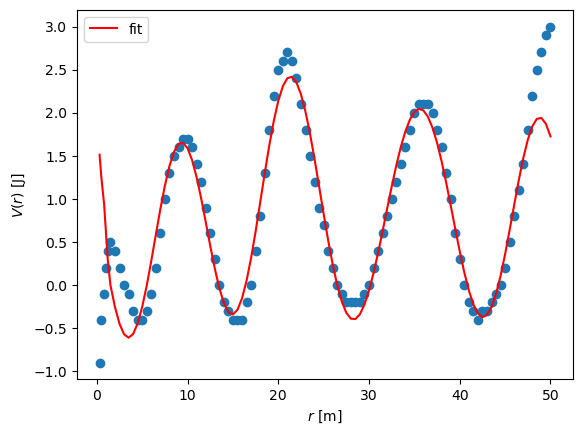

In [19]:
##### Display fitting
plt.scatter(r_data, V_data)
plt.xlabel('$r$ [m]', fontsize=10)
plt.ylabel('$V(r)$ [J]', fontsize=10)
plt.plot(r_data, V_fit.real, 'r-', label='fit')
plt.legend()
plt.show()